In [71]:
import numpy as np
import pandas as pd
import plotly.express as px

In [72]:
raw_df = pd.read_csv('data_preprocessed.csv')

#Encoder for Type of Nucleic Acid
''' {"2',4'-BNA/LNA-DNA": 0, "2'-O-Me-RNA": 1, "2'-amino-RNA": 2,
"2'-fluoro-RNA": 3, "2'-fluoro/O-Me-RNA": 4, "2'-fluoro/amino-RNA": 5,
"4'-thio-RNA": 6, '5-uracil-modified-DNA': 7, '5-uracil-modified-RNA': 8,
'FANA XNA': 9, 'dsDNA': 10, 'ssDNA': 11, 'ssRNA': 12}'''

# Encoder for Type of the buffer
#{'Not Reported': 0, 'Other Buffers': 1, 'PBS/phosphate buffers': 2, 'Tris Buffers': 3, nan: 4}

# Отфильтровываем строки в которых представлены данные по dsDNA
df = raw_df[raw_df['Type of Nucleic Acid'] == 11]
print(f'Осталось {len(df)} из {len(raw_df)}')

Осталось 450 из 751


In [73]:
#очистка от последовательностей с неправильными буквами
df = df[~df['Aptamer Sequence'].str.contains('S')]
df = df[~df['Aptamer Sequence'].str.contains('P')]
len(df)

448

In [74]:
df.columns

Index(['Type of Nucleic Acid', 'Aptamer Sequence', 'Sequence Length',
       'GC Content ', 'Kd (nM)', 'Type of the buffer', 'pH',
       'filtered_sequence'],
      dtype='object')

### Очистка последовательностей

В некоторых последовательностях (всего в 2) содержится X - пропущенные аминокислоты, поэтому мы его просто удаляем

In [75]:
df['filtered_sequence'].str.contains('X').sum()

2

In [76]:
df = df[~df['filtered_sequence'].str.contains('X')]

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 3 to 748
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Type of Nucleic Acid  446 non-null    int64  
 1   Aptamer Sequence      446 non-null    object 
 2   Sequence Length       446 non-null    int64  
 3   GC Content            446 non-null    float64
 4   Kd (nM)               446 non-null    float64
 5   Type of the buffer    446 non-null    int64  
 6   pH                    446 non-null    float64
 7   filtered_sequence     446 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 31.4+ KB


### Дескрипторы BioPython

https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html

In [78]:
!pip install biopython
from Bio.SeqUtils.ProtParam import ProteinAnalysis

Defaulting to user installation because normal site-packages is not writeable


In [79]:
def calculate_protein_descriptors(sequence):
    analysis = ProteinAnalysis(sequence)
    
    descriptors = {
        'molecular_weight': analysis.molecular_weight(),
        'aromaticity': analysis.aromaticity(),
        'instability_index': analysis.instability_index(),
        'isoelectric_point': analysis.isoelectric_point(),
        'helix_fraction': analysis.secondary_structure_fraction()[0],
        'turn_fraction': analysis.secondary_structure_fraction()[1],
        'sheet_fraction': analysis.secondary_structure_fraction()[2],
        'molar_extinction_coefficient_reduced': analysis.molar_extinction_coefficient()[0],
        'molar_extinction_coefficient_oxidized': analysis.molar_extinction_coefficient()[1],
        'gravy': analysis.gravy(),
        'filtered_sequence':sequence
    }
    
    return pd.Series(descriptors)

In [80]:
df_descriptors = df['filtered_sequence'].apply(calculate_protein_descriptors)
df_descriptors.head()

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,filtered_sequence
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...
4,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...
46,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,0.384211,2980,3230,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...
47,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,0.350380,261610,262860,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
48,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,0.350380,261610,262860,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...


In [81]:
df_descriptors_merged = pd.merge(df_descriptors, df.copy(), on='filtered_sequence')
df_descriptors_merged.head()

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,filtered_sequence,Type of Nucleic Acid,Aptamer Sequence,Sequence Length,GC Content,Kd (nM),Type of the buffer,pH
0,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,11,GGTTGGTGTGGTTGG,15,0.600000,112.5,3,7.4
1,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,11,GGTTGG,6,0.666667,112.5,3,7.4
2,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,11,GGTTGGTGTGGTTGG,15,0.600000,112.5,3,7.4
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,11,GGTTGG,6,0.666667,112.5,3,7.4
4,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,0.384211,2980,3230,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,11,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,6000.0,3,7.6


**Correlation heatmap**


In [82]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
def draw_heatmap(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                linewidths=.5, cbar_kws={"shrink": .8}, square=True)

    # Add title and adjust layout
    plt.title('Correlation Heatmap of df_descriptors', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the heatmap
    plt.show()

C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\38581238.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


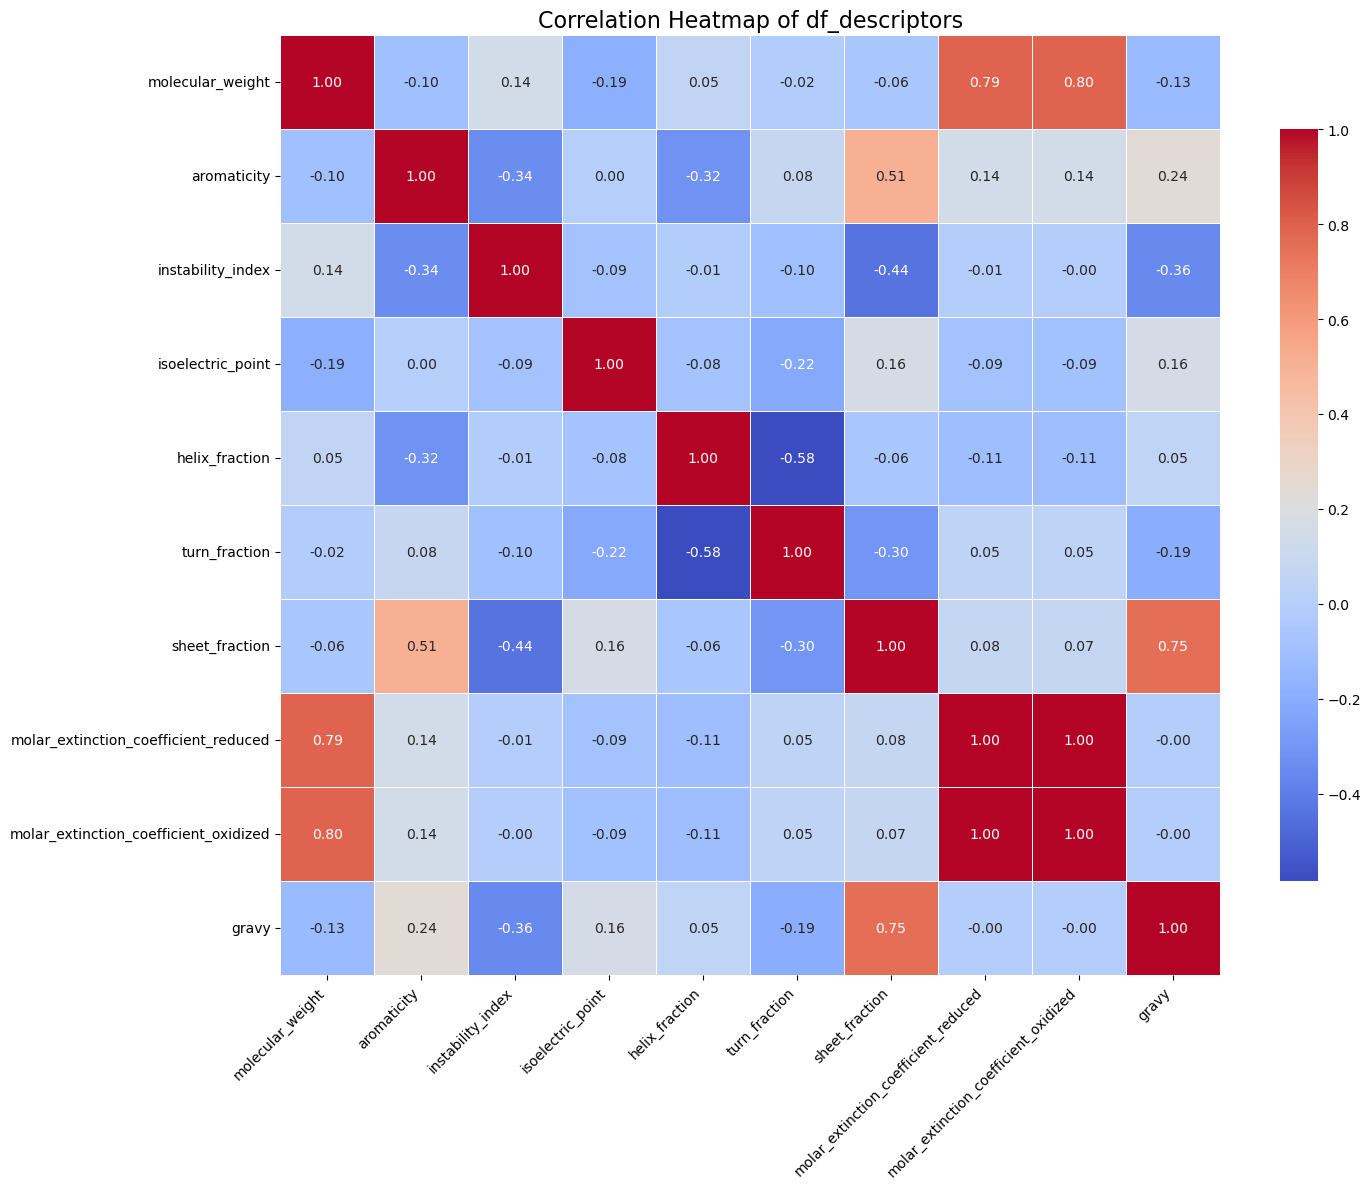

In [84]:
draw_heatmap(df_descriptors)

In [85]:
def identify_correlations(df, strong_threshold=0.75, moderate_threshold=0.5):
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Create a mask to ignore self-correlations (diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Apply the mask
    corr_matrix_masked = corr_matrix.mask(mask)

    # Identify strong positive correlations
    strong_positive = corr_matrix_masked[(corr_matrix_masked >= strong_threshold)]
    
    # Identify strong negative correlations
    strong_negative = corr_matrix_masked[(corr_matrix_masked <= -strong_threshold)]

    # Identify moderate positive correlations
    moderate_positive = corr_matrix_masked[(corr_matrix_masked >= moderate_threshold) & 
                                           (corr_matrix_masked < strong_threshold)]
    
    # Identify moderate negative correlations
    moderate_negative = corr_matrix_masked[(corr_matrix_masked <= -moderate_threshold) & 
                                           (corr_matrix_masked > -strong_threshold)]

    # Print strong positive correlations
    print("Strong Positive Correlations (Threshold: {}):".format(strong_threshold))
    for row in strong_positive.index:
        for col in strong_positive.columns:
            if pd.notna(strong_positive.loc[row, col]):
                print(f"{row} and {col}: {strong_positive.loc[row, col]:.2f}")

    print('---')
    
    # Print strong negative correlations
    print("\nStrong Negative Correlations (Threshold: {}):".format(strong_threshold))
    for row in strong_negative.index:
        for col in strong_negative.columns:
            if pd.notna(strong_negative.loc[row, col]):
                print(f"{row} and {col}: {strong_negative.loc[row, col]:.2f}")

    # Print moderate positive correlations
    print("\nModerate Positive Correlations (Threshold: {}):".format(moderate_threshold))
    for row in moderate_positive.index:
        for col in moderate_positive.columns:
            if pd.notna(moderate_positive.loc[row, col]):
                print(f"{row} and {col}: {moderate_positive.loc[row, col]:.2f}")

    print('---')
    
    # Print moderate negative correlations
    print("\nModerate Negative Correlations (Threshold: {}):".format(moderate_threshold))
    for row in moderate_negative.index:
        for col in moderate_negative.columns:
            if pd.notna(moderate_negative.loc[row, col]):
                print(f"{row} and {col}: {moderate_negative.loc[row, col]:.2f}")

    print('---')

In [86]:
identify_correlations(df_descriptors)

Strong Positive Correlations (Threshold: 0.75):
molar_extinction_coefficient_reduced and molecular_weight: 0.79
molar_extinction_coefficient_oxidized and molecular_weight: 0.80
molar_extinction_coefficient_oxidized and molar_extinction_coefficient_reduced: 1.00
gravy and sheet_fraction: 0.75
---

Strong Negative Correlations (Threshold: 0.75):

Moderate Positive Correlations (Threshold: 0.5):
sheet_fraction and aromaticity: 0.51
---

Moderate Negative Correlations (Threshold: 0.5):
turn_fraction and helix_fraction: -0.58
---


C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\2655871282.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


**Выводы из корреляций:**
- По коэффициентам корелляции можно сделать следующий вывод: чем больше частица, тем лучше происходит поглощение света, а значит больше молярная экстинкция, данная корелляция очевидна
- что касается второй строчки,молярный коэффициент поглощения (также известный как молярная поглощательная способность) является показателем того, насколько сильно вещество поглощает свет на определенной длине волны. Второй параметр, это, по сути, то же самое.Тут тоже происходит поглощение на разных длинах волн (на окисленной и восстановленной формах).Поэтому между этими параметрами очень сильная корелляция
- параметр gravy является мерой гидрофобности белка.Бета-листы в белках обычно характеризуются тем, что аминокислоты, образующие их структуру, имеют гидрофобные свойства. Поэтому здесь достаточно сильная корелляция
- бета-листы, как правило, гидрофобны.Ароматические кольца могут участвовать в гидрофобных взаимодействиях, которые способствуют свертыванию белка и его стабилизации. Поэтому здесь прослеживается не слишком сильная корелляция.
- первый параметр показывает долю петель в белке, второй- долю альфа-спиралей.На образование петель и спиралей нужно пространство.Отсюда, чем больше петель, тем меньше альфа-спиралей может образоваться.Здесь мы наблюдаем обратную корелляцию

In [87]:
df_descriptors_filtered=df_descriptors.drop(['molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'sheet_fraction'], axis=1)
df_descriptors_filtered

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,filtered_sequence
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...
4,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...
46,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...
47,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
48,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
...,...,...,...,...,...,...,...,...
728,53651.0423,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...
730,92461.9469,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
731,92461.9469,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
747,117530.2268,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...


Boxplots and Outliers

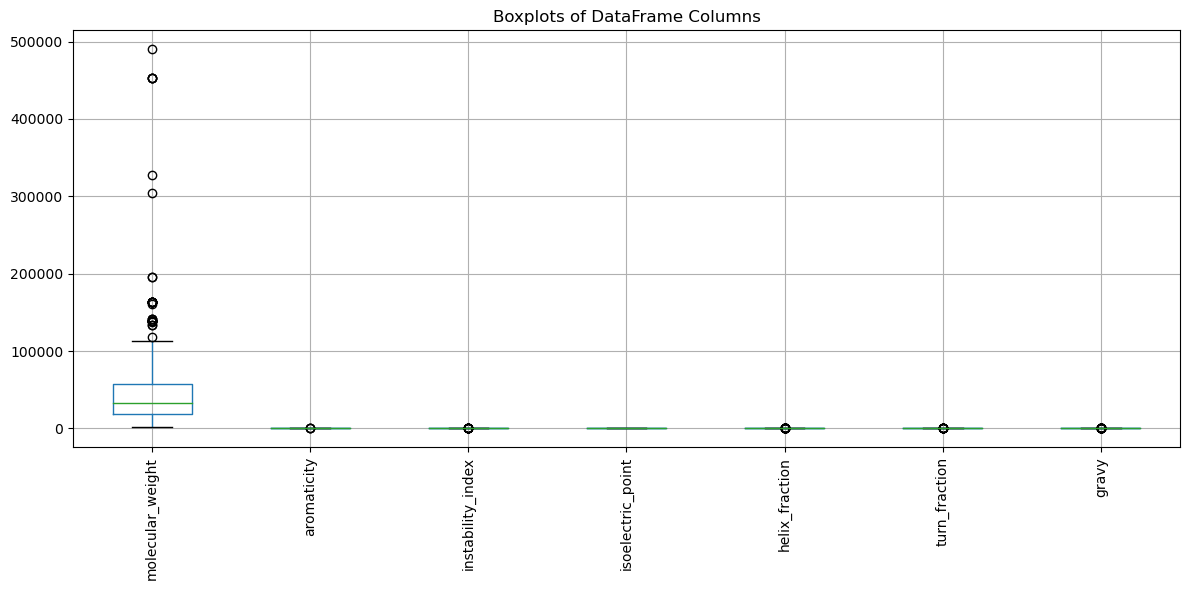

In [88]:
def plot_boxplots(df):
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    df.boxplot()  # Строим боксплоты для всех столбцов датафрейма
    plt.xticks(rotation=90)  # Поворачиваем подписи по оси X, чтобы они не перекрывались
    plt.title('Boxplots of DataFrame Columns')  # Устанавливаем заголовок графика
    plt.grid(True)  # Включаем сетку
    plt.tight_layout()  # Улучшаем отображение графика

    plt.show()  # Отображаем график
plot_boxplots(df_descriptors_filtered.drop('filtered_sequence', axis=1))

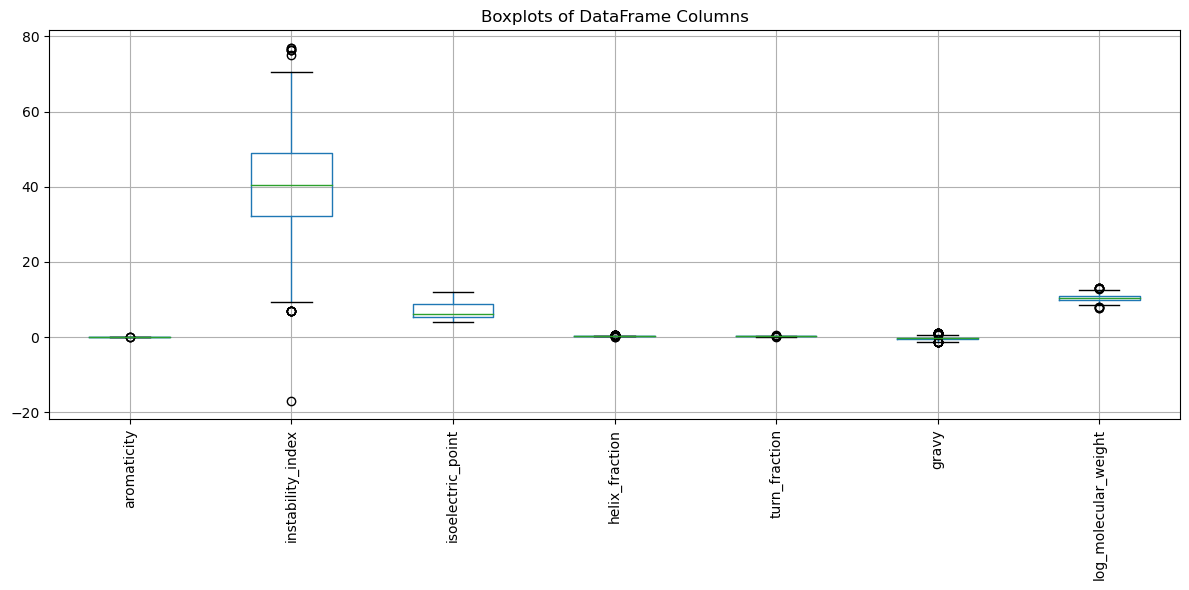

In [89]:

df_descriptors_filtered['log_molecular_weight'] = np.log(df_descriptors_filtered['molecular_weight'])
df_descriptors_filtered = df_descriptors_filtered.drop('molecular_weight', axis=1)
plot_boxplots(df_descriptors_filtered.drop('filtered_sequence', axis=1))

После логарифмирования молекулярного веса среди данных не наблюдается значительных выбросов и они приведены к более-менее одной шкале

### Дескрипторы PyBioMed 

In [90]:
!pip install PyBioMed

Defaulting to user installation because normal site-packages is not writeable


In [91]:
#Дескрипторы для белков
#дескрипторы CTD описывают долю аминокислот с определенными химическими свойствами (C), 
#а также корреляцию между аминокислотами с разными химическими свойствами (T) 
from PyBioMed.PyProtein import CTD

def pybiomed_proteinCT(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return a

new_cols = list(pybiomed_proteinCT('AAA').keys())
def pybiomed_proteinCT2(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return [seq]+list(a.values())

len(pybiomed_proteinCT2('AAA'))
pybiomed_df = df.copy()

prottups = pybiomed_df['filtered_sequence'].apply(pybiomed_proteinCT2)
pybiomed_prot_df = pd.DataFrame(prottups.to_list(), columns=['filtered_sequence']+new_cols)
pybiomed_prot_df

,filtered_sequence,_PolarizabilityC1,_PolarizabilityC2,_PolarizabilityC3,_SolventAccessibilityC1,_SolventAccessibilityC2,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,...,_ChargeT23,_PolarityT12,_PolarityT13,_PolarityT23,_NormalizedVDWVT12,_NormalizedVDWVT13,_NormalizedVDWVT23,_HydrophobicityT12,_HydrophobicityT13,_HydrophobicityT23
0,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.347,0.224,0.429,0.295,0.276,...,0.189,0.153,0.124,0.072,0.199,0.202,0.218,0.212,0.218,0.205
1,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.347,0.224,0.429,0.295,0.276,...,0.189,0.153,0.124,0.072,0.199,0.202,0.218,0.212,0.218,0.205
2,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,0.300,0.489,0.211,0.458,0.300,0.242,0.389,0.311,0.300,...,0.143,0.143,0.085,0.069,0.296,0.132,0.190,0.185,0.201,0.259
3,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.290,0.461,0.249,0.416,0.357,0.227,0.456,0.288,0.256,...,0.170,0.159,0.104,0.071,0.270,0.158,0.202,0.233,0.227,0.205
4,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.290,0.461,0.249,0.416,0.357,0.227,0.456,0.288,0.256,...,0.170,0.159,0.104,0.071,0.270,0.158,0.202,0.233,0.227,0.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,0.309,0.466,0.225,0.333,0.440,0.227,0.552,0.195,0.253,...,0.260,0.176,0.108,0.067,0.280,0.140,0.198,0.234,0.288,0.157
442,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,0.286,0.446,0.268,0.410,0.334,0.256,0.425,0.288,0.287,...,0.193,0.155,0.088,0.053,0.275,0.195,0.213,0.231,0.214,0.231
443,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,0.286,0.446,0.268,0.410,0.334,0.256,0.425,0.288,0.287,...,0.193,0.155,0.088,0.053,0.275,0.195,0.213,0.231,0.214,0.231
444,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,0.317,0.463,0.219,0.428,0.312,0.260,0.458,0.259,0.283,...,0.162,0.130,0.097,0.065,0.305,0.148,0.172,0.247,0.178,0.230


In [92]:
identify_correlations(pybiomed_prot_df)

C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\2655871282.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Strong Positive Correlations (Threshold: 0.75):
_ChargeC3 and _SolventAccessibilityC2: 0.81
_PolarityC3 and _ChargeC1: 0.95
_NormalizedVDWVC1 and _PolarizabilityC1: 0.91
_NormalizedVDWVC3 and _PolarizabilityC3: 1.00
_HydrophobicityC1 and _SolventAccessibilityC2: 1.00
_HydrophobicityC1 and _ChargeC3: 0.81
_HydrophobicityC2 and _PolarizabilityC1: 0.80
_HydrophobicityC2 and _NormalizedVDWVC1: 0.93
_HydrophobicityC3 and _PolarityC1: 0.97
_SolventAccessibilityT13 and _ChargeC2: 0.78
_ChargeT12 and _ChargeC1: 0.92
_ChargeT12 and _PolarityC3: 0.87
_ChargeT23 and _ChargeC3: 0.94
_PolarityT23 and _SolventAccessibilityC2: 0.79
_PolarityT23 and _HydrophobicityC1: 0.79
_NormalizedVDWVT12 and _PolarizabilityT12: 0.76
_NormalizedVDWVT13 and _PolarizabilityT13: 0.93
_NormalizedVDWVT23 and _PolarizabilityT23: 0.86
_HydrophobicityT23 and _SolventAccessibilityC1: 0.79
_HydrophobicityT23 and _ChargeC2: 0.77
---

Strong Negative Correlations (Threshold: 0.75):
_SolventAccessibilityC2 and _SolventAccessibi

In [93]:
def corr_deler(df):
    ans = []
    corr_matrix = df.corr(method='pearson')
# Loop over bottom diagonal of correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.75:
                #print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                ans.append(corr_matrix.columns[i])
    
    return list(set(ans))
                
to_del = corr_deler(pybiomed_prot_df)
print(len(to_del))
pybiomed_prot_df = pybiomed_prot_df.drop(to_del, axis=1)
pybiomed_prot_df.head(1)

23


C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\1547990591.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


,filtered_sequence,_PolarizabilityC1,_PolarizabilityC2,_PolarizabilityC3,_SolventAccessibilityC1,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,_ChargeC1,_PolarityC1,_PolarityC2,_NormalizedVDWVC2,_PolarizabilityT12,_SolventAccessibilityT12,_SecondaryStrT12,_SecondaryStrT13,_PolarityT12,_PolarityT13,_HydrophobicityT13
0,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.224,0.429,0.295,0.276,0.149,0.354,0.188,0.341,0.212,0.3,0.257,0.257,0.153,0.124,0.218


C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\38581238.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


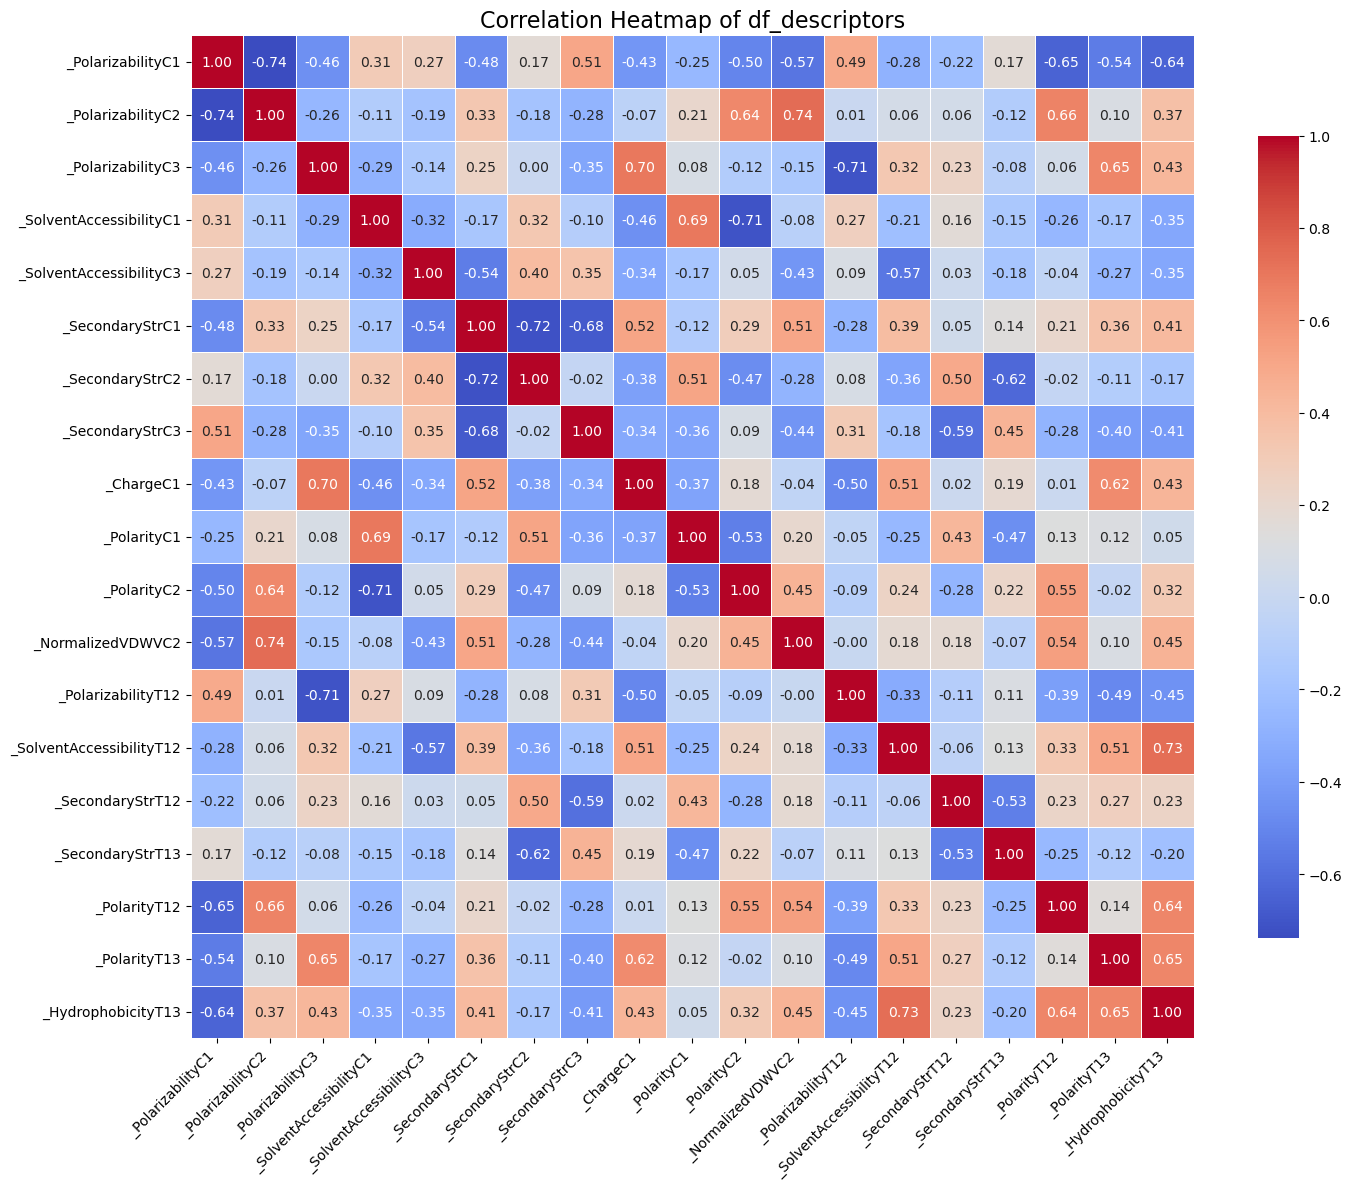

In [94]:
draw_heatmap(pybiomed_prot_df)

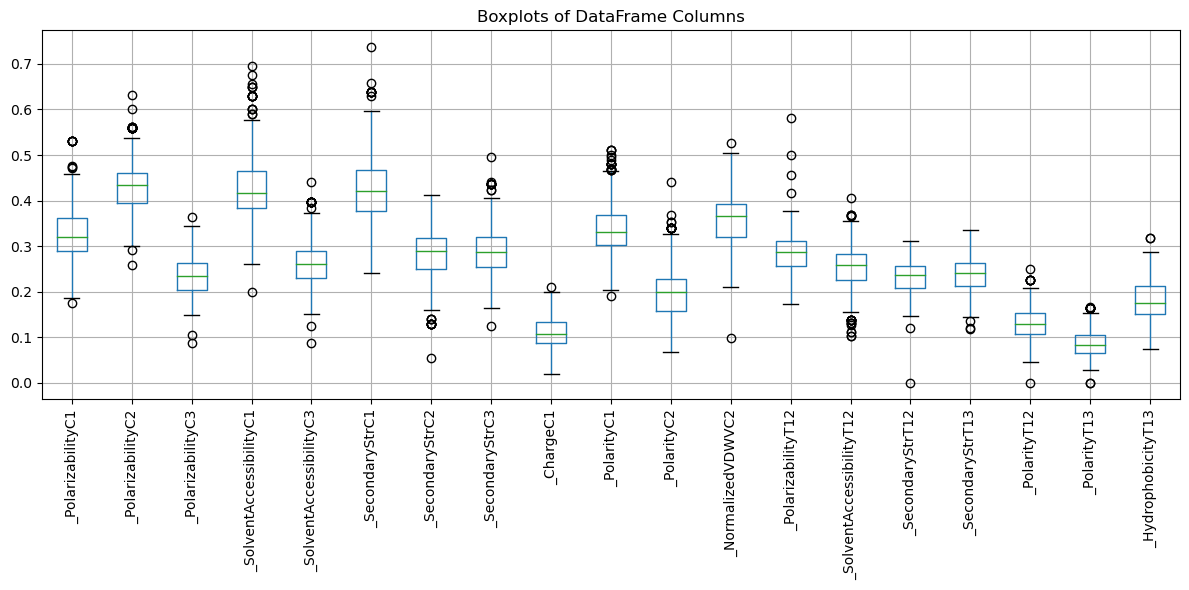

In [95]:
plot_boxplots(pybiomed_prot_df)

In [96]:
#Дескрипторы корреляций оснований днк с разными физико-химическими свойствами  
from PyBioMed.PyDNA.PyDNAac import GetDAC

def pybiomed_dac(seq):
    a = GetDAC(seq, all_property=True)
    return a

new_colsdna = list(pybiomed_dac('AATTTTA').keys())
def pybiomed_dac2(seq):
    a = GetDAC(seq, all_property=True)
    return [seq]+list(a.values())

#len(pybiomed_dac('AATTTTA'))
pybiomed_df2 = df.copy()

dnatups = pybiomed_df2['Aptamer Sequence'].apply(pybiomed_dac2)
pybiomed_dna_df = pd.DataFrame(dnatups.to_list(), columns=['Aptamer Sequence']+new_colsdna)
pybiomed_dna_df.head(1)

,Aptamer Sequence,DAC_1,DAC_2,DAC_3,DAC_4,DAC_5,DAC_6,DAC_7,DAC_8,DAC_9,...,DAC_67,DAC_68,DAC_69,DAC_70,DAC_71,DAC_72,DAC_73,DAC_74,DAC_75,DAC_76
0,GGTTGGTGTGGTTGG,-0.17,-0.333,-0.09,-0.01,-0.379,-0.08,-0.042,-0.282,-0.235,...,-0.281,-0.223,-0.188,-0.635,-0.333,0.047,-0.213,0.261,-0.168,-0.221


In [97]:
to_del2 = corr_deler(pybiomed_dna_df)
print(len(to_del2))
pybiomed_dna_df = pybiomed_dna_df.drop(to_del2, axis=1)
pybiomed_dna_df.head(1)

48


C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\1547990591.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


,Aptamer Sequence,DAC_1,DAC_2,DAC_3,DAC_4,DAC_5,DAC_6,DAC_11,DAC_13,DAC_26,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,GGTTGGTGTGGTTGG,-0.17,-0.333,-0.09,-0.01,-0.379,-0.08,-0.302,-0.158,-0.25,...,-0.81,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168


C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\38581238.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


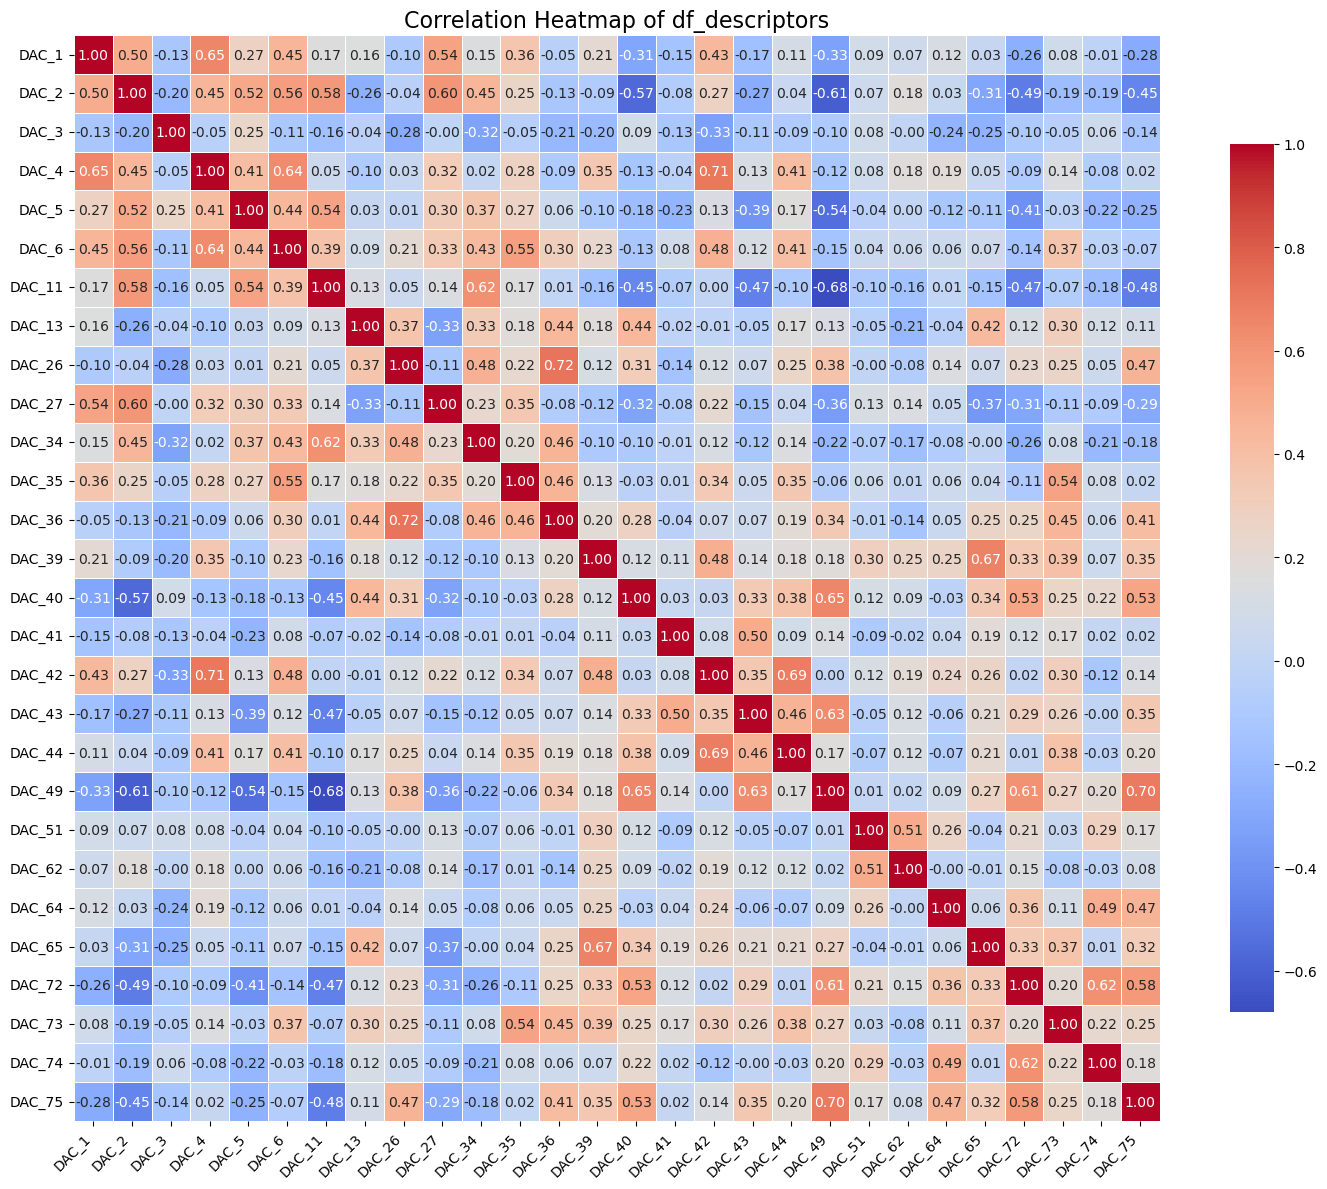

In [98]:
draw_heatmap(pybiomed_dna_df)

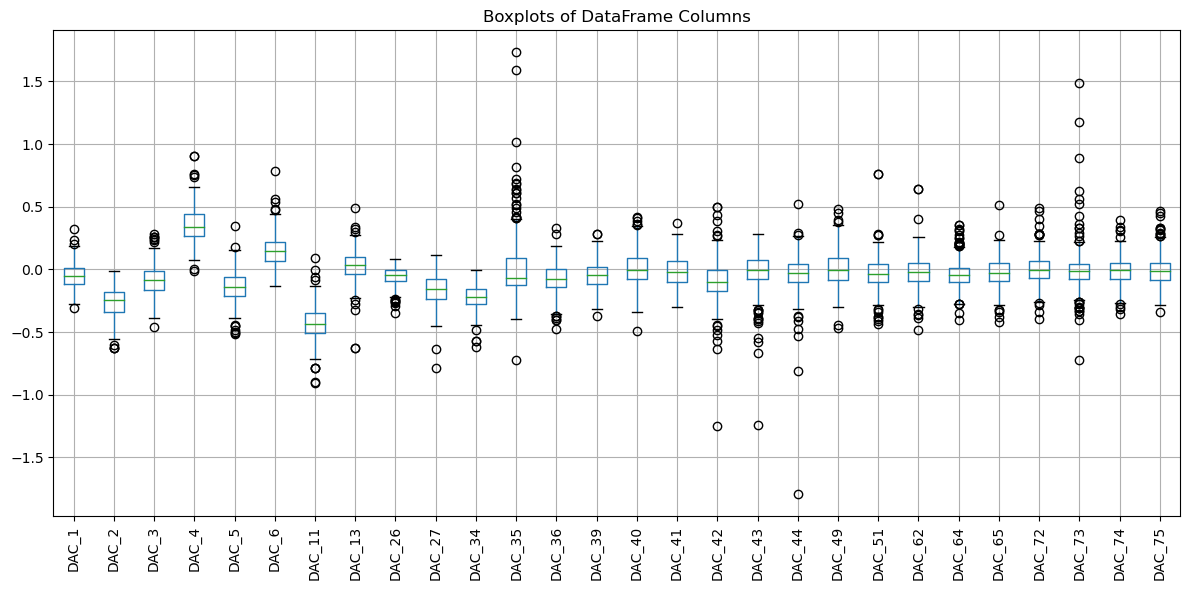

In [99]:
plot_boxplots(pybiomed_dna_df.drop('Aptamer Sequence', axis=1))

Хотя в целом по отдельным дескрипторам есть точки, которые можно квалифицировать как выбросы, они не очень далеко удаляются от среднего (не отличаются по порядку).
Считаю нецелесообразным их отфильтровывать т.к. датасет и так небольшой 

Посмотрим на изначальные данные более пристально

<Axes: >

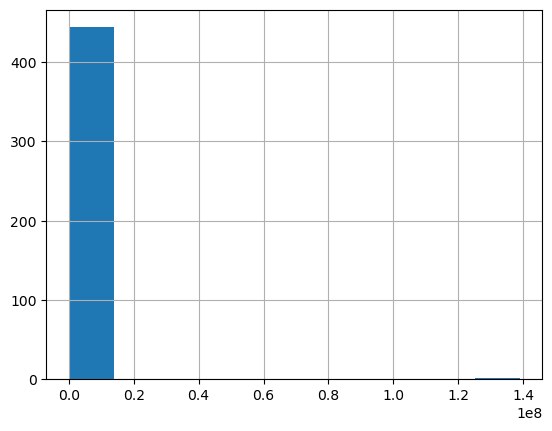

In [100]:
df['Kd (nM)'].hist()
#выглядит не очень, попробуем логарифмировать

<Axes: >

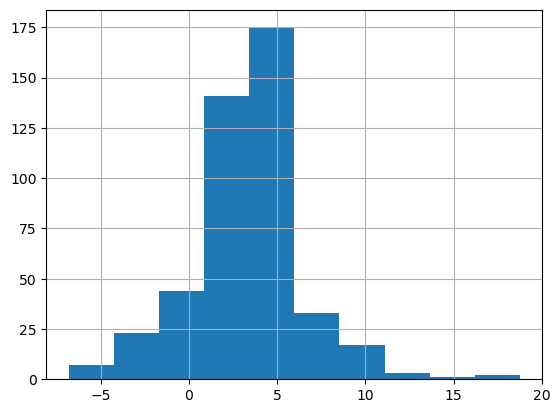

In [101]:
df['log_Kd'] = np.log(df['Kd (nM)'])
df['log_Kd'].hist()
#уже значительно лучше

In [102]:
df.columns

Index(['Type of Nucleic Acid', 'Aptamer Sequence', 'Sequence Length',
       'GC Content ', 'Kd (nM)', 'Type of the buffer', 'pH',
       'filtered_sequence', 'log_Kd'],
      dtype='object')

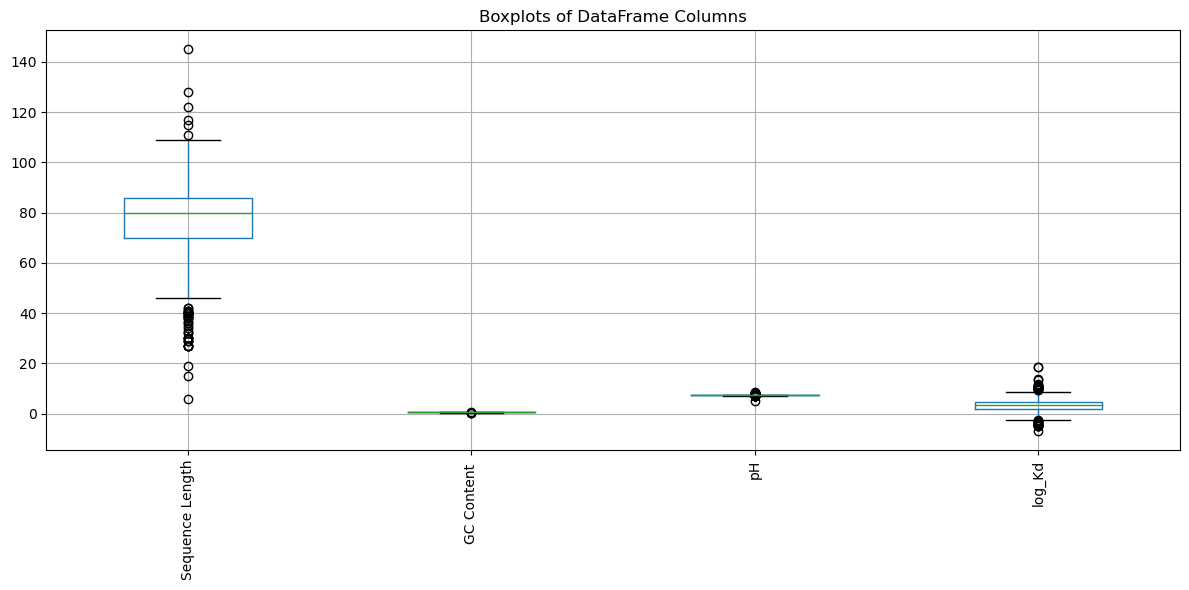

In [103]:
plot_boxplots(df.drop(['Type of Nucleic Acid', 'Aptamer Sequence', 'Kd (nM)', 'Type of the buffer'], axis=1))

C:\Users\Макс\AppData\Local\Temp\ipykernel_13544\38581238.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


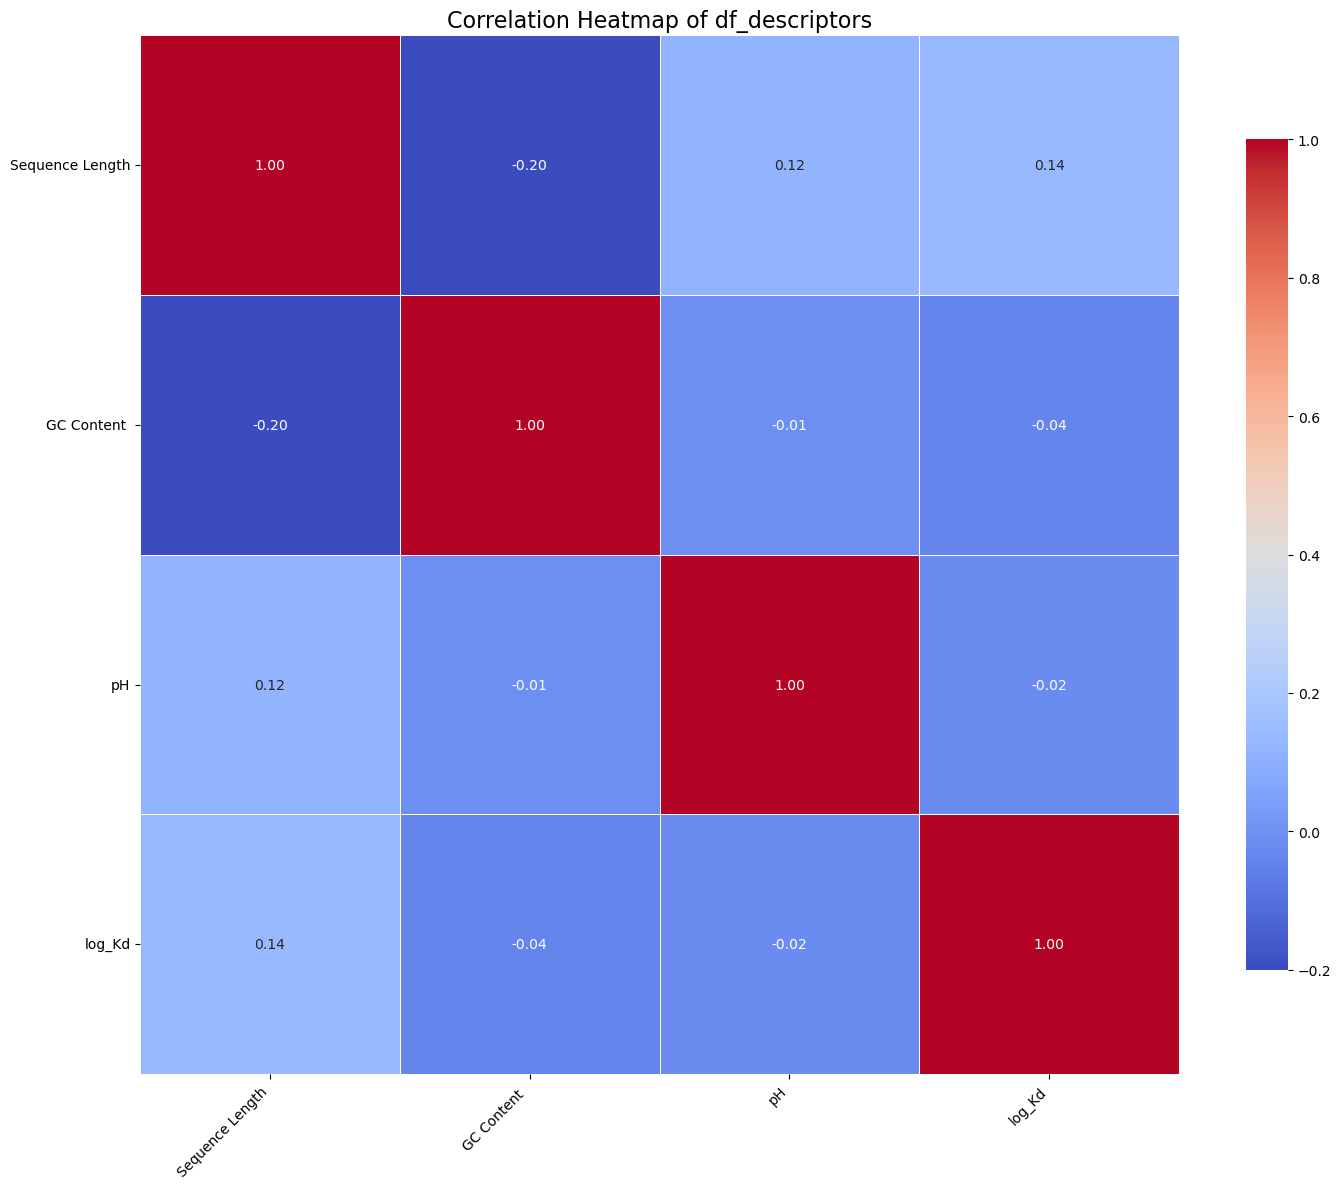

In [104]:
draw_heatmap(df.drop(['Type of Nucleic Acid', 'Aptamer Sequence', 'Kd (nM)', 'Type of the buffer'], axis=1))

In [105]:
full_df = pd.concat([df, df_descriptors_filtered.drop('filtered_sequence', axis=1)], axis=1)
full_df

,Type of Nucleic Acid,Aptamer Sequence,Sequence Length,GC Content,Kd (nM),Type of the buffer,pH,filtered_sequence,log_Kd,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,log_molecular_weight
3,11,GGTTGGTGTGGTTGG,15,0.600000,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,10.475489
4,11,GGTTGG,6,0.666667,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,10.475489
46,11,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,6000.000,3,7.6,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,8.699515,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,9.938508
47,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,81,0.444444,1.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.000000,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,12.003261
48,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,53,0.471698,4.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,1.386294,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,12.003261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,11,ATCCAGAGTGACGCAGCAGGGCACATTGTTCACACACAGATCACAT...,85,0.494118,12.800,2,7.4,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,2.549445,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,10.890256
730,11,CACGACGACAGAGACCACAGCACGTGGCCCACGTTAATCCGTTATA...,79,0.544304,89.410,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,4.493233,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,11.434552
731,11,CACGACGACAGAGACCACAGGGGGGCGTCAAGCGGGGTCACATCGG...,80,0.612500,231.900,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,5.446306,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,11.434552
747,11,ATCTAACTGCTGCGCCGCCGGGAAAATACTGTACGGTTAGA,41,0.512195,0.800,2,7.4,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-0.223144,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,11.674451


In [106]:
full_df = pd.merge(
    full_df, pybiomed_prot_df,
    left_on='filtered_sequence',
    right_on='filtered_sequence',
    how='left'
).drop_duplicates()
full_df

,Type of Nucleic Acid,Aptamer Sequence,Sequence Length,GC Content,Kd (nM),Type of the buffer,pH,filtered_sequence,log_Kd,aromaticity,...,_PolarityC1,_PolarityC2,_NormalizedVDWVC2,_PolarizabilityT12,_SolventAccessibilityT12,_SecondaryStrT12,_SecondaryStrT13,_PolarityT12,_PolarityT13,_HydrophobicityT13
0,11,GGTTGGTGTGGTTGG,15,0.600000,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,...,0.354,0.188,0.341,0.212,0.300,0.257,0.257,0.153,0.124,0.218
2,11,GGTTGG,6,0.666667,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,...,0.354,0.188,0.341,0.212,0.300,0.257,0.257,0.153,0.124,0.218
4,11,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,6000.000,3,7.6,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,8.699515,0.047368,...,0.347,0.200,0.395,0.302,0.275,0.217,0.217,0.143,0.085,0.201
5,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,81,0.444444,1.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.000000,0.076710,...,0.323,0.236,0.393,0.277,0.305,0.253,0.212,0.159,0.104,0.227
14,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,53,0.471698,4.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,1.386294,0.076710,...,0.323,0.236,0.393,0.277,0.305,0.253,0.212,0.159,0.104,0.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,11,ATCCAGAGTGACGCAGCAGGGCACATTGTTCACACACAGATCACAT...,85,0.494118,12.800,2,7.4,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,2.549445,0.051502,...,0.281,0.258,0.444,0.284,0.340,0.215,0.245,0.176,0.108,0.288
2312,11,CACGACGACAGAGACCACAGCACGTGGCCCACGTTAATCCGTTATA...,79,0.544304,89.410,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,4.493233,0.118012,...,0.368,0.230,0.390,0.265,0.276,0.240,0.241,0.155,0.088,0.214
2316,11,CACGACGACAGAGACCACAGGGGGGCGTCAAGCGGGGTCACATCGG...,80,0.612500,231.900,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,5.446306,0.118012,...,0.368,0.230,0.390,0.265,0.276,0.240,0.241,0.155,0.088,0.214
2320,11,ATCTAACTGCTGCGCCGCCGGGAAAATACTGTACGGTTAGA,41,0.512195,0.800,2,7.4,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-0.223144,0.068738,...,0.315,0.234,0.365,0.305,0.275,0.237,0.282,0.130,0.097,0.178


In [107]:
full_df = pd.merge(
    full_df, pybiomed_dna_df,
    left_on='Aptamer Sequence',
    right_on='Aptamer Sequence',
    how='left'
).drop_duplicates()
full_df

,Type of Nucleic Acid,Aptamer Sequence,Sequence Length,GC Content,Kd (nM),Type of the buffer,pH,filtered_sequence,log_Kd,aromaticity,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,11,GGTTGGTGTGGTTGG,15,0.600000,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,...,-0.810,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168
1,11,GGTTGG,6,0.666667,112.500,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,...,-1.791,-0.470,0.285,-0.263,0.326,-0.419,0.107,-0.726,0.394,-0.286
2,11,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,6000.000,3,7.6,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,8.699515,0.047368,...,-0.055,-0.014,0.192,0.099,0.058,-0.037,-0.001,0.052,0.105,0.085
3,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,81,0.444444,1.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.000000,0.076710,...,0.018,-0.084,-0.020,-0.183,0.191,-0.083,-0.094,0.031,0.061,0.062
4,11,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,53,0.471698,4.000,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,1.386294,0.076710,...,0.052,-0.117,-0.094,-0.117,-0.131,-0.084,-0.104,0.043,-0.092,-0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,11,ATCCAGAGTGACGCAGCAGGGCACATTGTTCACACACAGATCACAT...,85,0.494118,12.800,2,7.4,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,2.549445,0.051502,...,-0.025,0.170,-0.131,-0.054,0.034,0.025,0.127,0.069,0.045,0.021
492,11,CACGACGACAGAGACCACAGCACGTGGCCCACGTTAATCCGTTATA...,79,0.544304,89.410,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,4.493233,0.118012,...,0.040,0.027,-0.034,-0.002,-0.079,-0.047,0.093,-0.000,0.069,-0.157
493,11,CACGACGACAGAGACCACAGGGGGGCGTCAAGCGGGGTCACATCGG...,80,0.612500,231.900,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,5.446306,0.118012,...,0.003,0.094,-0.021,-0.002,0.006,-0.085,0.027,-0.003,-0.015,0.027
494,11,ATCTAACTGCTGCGCCGCCGGGAAAATACTGTACGGTTAGA,41,0.512195,0.800,2,7.4,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-0.223144,0.068738,...,0.240,0.032,0.158,-0.066,0.065,-0.028,-0.030,-0.012,0.051,0.016


In [108]:
df.columns

Index(['Type of Nucleic Acid', 'Aptamer Sequence', 'Sequence Length',
       'GC Content ', 'Kd (nM)', 'Type of the buffer', 'pH',
       'filtered_sequence', 'log_Kd'],
      dtype='object')

In [109]:
full_df = full_df.drop(['Type of Nucleic Acid', 'Kd (nM)'], axis=1)
full_df.head(1)

,Aptamer Sequence,Sequence Length,GC Content,Type of the buffer,pH,filtered_sequence,log_Kd,aromaticity,instability_index,isoelectric_point,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,GGTTGGTGTGGTTGG,15,0.6,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,32.264643,8.781448,...,-0.81,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168


In [110]:
analysis_df = full_df.drop(['Aptamer Sequence', 'filtered_sequence'],axis=1)
analysis_df.head()

,Sequence Length,GC Content,Type of the buffer,pH,log_Kd,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,15,0.600000,3,7.4,4.722953,0.107143,32.264643,8.781448,0.295455,0.275974,...,-0.810,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168
1,6,0.666667,3,7.4,4.722953,0.107143,32.264643,8.781448,0.295455,0.275974,...,-1.791,-0.470,0.285,-0.263,0.326,-0.419,0.107,-0.726,0.394,-0.286
2,42,0.595238,3,7.6,8.699515,0.047368,46.075316,9.605870,0.252632,0.300000,...,-0.055,-0.014,0.192,0.099,0.058,-0.037,-0.001,0.052,0.105,0.085
3,81,0.444444,3,8.0,0.000000,0.076710,38.542585,8.926180,0.325501,0.255701,...,0.018,-0.084,-0.020,-0.183,0.191,-0.083,-0.094,0.031,0.061,0.062
4,53,0.471698,3,8.0,1.386294,0.076710,38.542585,8.926180,0.325501,0.255701,...,0.052,-0.117,-0.094,-0.117,-0.131,-0.084,-0.104,0.043,-0.092,-0.048


In [111]:
identify_correlations(analysis_df.drop('log_Kd',axis=1))
analysis_df = analysis_df.drop(['_SolventAccessibilityC1', '_SecondaryStrC1', '_SecondaryStrC3', '_PolarityC1'], axis=1)
analysis_df.describe()

Strong Positive Correlations (Threshold: 0.75):
_SolventAccessibilityC1 and gravy: 0.91
_SecondaryStrC1 and helix_fraction: 0.82
_SecondaryStrC3 and turn_fraction: 1.00
_PolarityC1 and gravy: 0.82
---

Strong Negative Correlations (Threshold: 0.75):

Moderate Positive Correlations (Threshold: 0.5):
_PolarizabilityC1 and turn_fraction: 0.51
_PolarizabilityC2 and instability_index: 0.50
_SecondaryStrC2 and aromaticity: 0.59
_SecondaryStrC3 and _PolarizabilityC1: 0.51
_ChargeC1 and _PolarizabilityC3: 0.70
_ChargeC1 and _SecondaryStrC1: 0.52
_PolarityC1 and _SolventAccessibilityC1: 0.69
_PolarityC1 and _SecondaryStrC2: 0.51
_PolarityC2 and instability_index: 0.59
_PolarityC2 and _PolarizabilityC2: 0.64
_NormalizedVDWVC2 and helix_fraction: 0.55
_NormalizedVDWVC2 and _PolarizabilityC2: 0.74
_NormalizedVDWVC2 and _SecondaryStrC1: 0.51
_SolventAccessibilityT12 and _ChargeC1: 0.51
_PolarityT12 and _PolarizabilityC2: 0.66
_PolarityT12 and _PolarityC2: 0.55
_PolarityT12 and _NormalizedVDWVC2: 0.

,Sequence Length,GC Content,Type of the buffer,pH,log_Kd,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,...,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,75.683857,0.528468,2.154709,7.518692,3.339780,0.082621,40.168912,6.985834,0.313286,0.290058,...,-0.030439,0.003226,-0.030159,-0.022471,-0.039110,-0.029025,-0.003464,-0.007529,-0.011343,-0.006175
std,18.818138,0.069885,0.902338,0.274372,3.169026,0.026988,13.240573,1.890534,0.063669,0.049836,...,0.148818,0.136878,0.122147,0.121169,0.101998,0.115101,0.114632,0.158430,0.102626,0.115710
min,6.000000,0.289474,0.000000,5.000000,-6.803395,0.000000,-17.104348,4.137390,0.160000,0.125000,...,-1.791000,-0.470000,-0.436000,-0.486000,-0.400000,-0.419000,-0.397000,-0.726000,-0.357000,-0.336000
25%,70.000000,0.481593,2.000000,7.400000,1.793834,0.062112,32.264643,5.339762,0.276978,0.253797,...,-0.100750,-0.082000,-0.099500,-0.089750,-0.102500,-0.095750,-0.069000,-0.074750,-0.074750,-0.082750
50%,80.000000,0.529706,2.000000,7.466744,3.597218,0.082143,40.351304,6.270841,0.311343,0.287037,...,-0.027000,-0.002000,-0.034000,-0.018000,-0.047500,-0.026000,-0.007500,-0.015000,-0.006500,-0.013000
75%,86.000000,0.576632,3.000000,7.600000,4.653960,0.101417,48.956946,8.859842,0.336391,0.318878,...,0.046750,0.094750,0.042000,0.051750,0.011000,0.049500,0.065500,0.045000,0.053000,0.054750
max,145.000000,0.780488,4.000000,8.500000,18.749984,0.154867,76.896639,11.956323,0.684211,0.494624,...,0.521000,0.481000,0.760000,0.640000,0.352000,0.514000,0.488000,1.487000,0.394000,0.465000


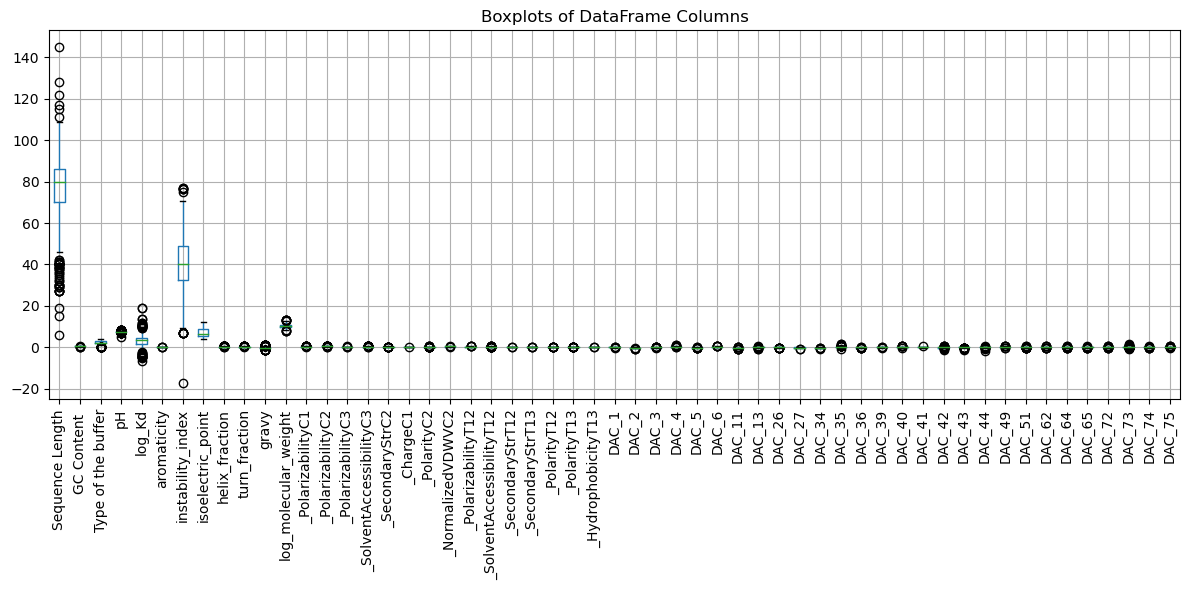

In [112]:
plot_boxplots(analysis_df)

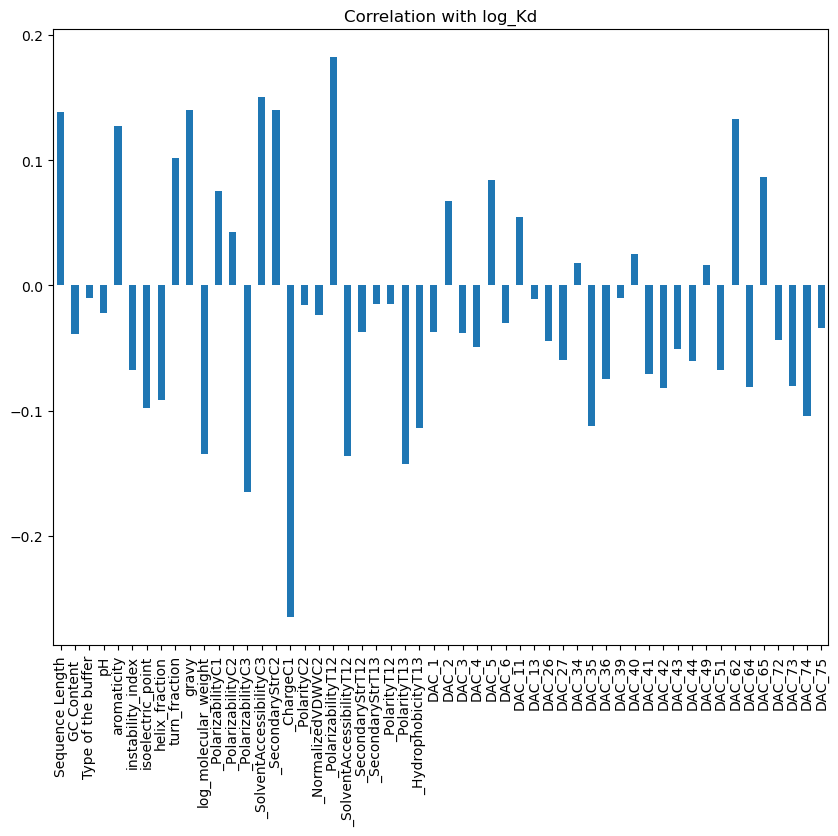

In [113]:
corr_matrix = analysis_df.corr()
plt.figure(figsize=(10, 8))
corr_matrix['log_Kd'].drop('log_Kd').plot(kind='bar')
plt.title('Correlation with log_Kd')
plt.show()

In [116]:
full_df.drop(['_SolventAccessibilityC1', '_SecondaryStrC1', '_SecondaryStrC3', '_PolarityC1'], axis=1)

,Aptamer Sequence,Sequence Length,GC Content,Type of the buffer,pH,filtered_sequence,log_Kd,aromaticity,instability_index,isoelectric_point,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,GGTTGGTGTGGTTGG,15,0.600000,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,32.264643,8.781448,...,-0.810,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168
1,GGTTGG,6,0.666667,3,7.4,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,4.722953,0.107143,32.264643,8.781448,...,-1.791,-0.470,0.285,-0.263,0.326,-0.419,0.107,-0.726,0.394,-0.286
2,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,3,7.6,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,8.699515,0.047368,46.075316,9.605870,...,-0.055,-0.014,0.192,0.099,0.058,-0.037,-0.001,0.052,0.105,0.085
3,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,81,0.444444,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.000000,0.076710,38.542585,8.926180,...,0.018,-0.084,-0.020,-0.183,0.191,-0.083,-0.094,0.031,0.061,0.062
4,CCCCTGCAGGTGATTTTGCTCAAGTCAGAAGGATAAACTGTCCAGA...,53,0.471698,3,8.0,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,1.386294,0.076710,38.542585,8.926180,...,0.052,-0.117,-0.094,-0.117,-0.131,-0.084,-0.104,0.043,-0.092,-0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,ATCCAGAGTGACGCAGCAGGGCACATTGTTCACACACAGATCACAT...,85,0.494118,2,7.4,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,2.549445,0.051502,58.075751,5.063468,...,-0.025,0.170,-0.131,-0.054,0.034,0.025,0.127,0.069,0.045,0.021
492,CACGACGACAGAGACCACAGCACGTGGCCCACGTTAATCCGTTATA...,79,0.544304,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,4.493233,0.118012,40.088211,5.361588,...,0.040,0.027,-0.034,-0.002,-0.079,-0.047,0.093,-0.000,0.069,-0.157
493,CACGACGACAGAGACCACAGGGGGGCGTCAAGCGGGGTCACATCGG...,80,0.612500,3,7.0,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,5.446306,0.118012,40.088211,5.361588,...,0.003,0.094,-0.021,-0.002,0.006,-0.085,0.027,-0.003,-0.015,0.027
494,ATCTAACTGCTGCGCCGCCGGGAAAATACTGTACGGTTAGA,41,0.512195,2,7.4,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-0.223144,0.068738,50.059520,6.400377,...,0.240,0.032,0.158,-0.066,0.065,-0.028,-0.030,-0.012,0.051,0.016


In [118]:
final_df = full_df.drop(['_SolventAccessibilityC1', '_SecondaryStrC1', '_SecondaryStrC3', '_PolarityC1'], axis=1)
final_df.to_csv('descriptors.csv', index=False) # csv без индексов